In [1]:
MODEL_DIR = "models"

In [2]:
import itertools
import json
from copy import deepcopy
from functools import partial
from os import makedirs
from pathlib import Path
from typing import Any, Optional

import graphviz
import numpy as np
import pydot
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_covtype, load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras, nn
from tensorflow.keras import callbacks, layers
from tensorflow.keras import utils as kutils
from tensorflow.keras.applications import (
    VGG19,
    InceptionV3,
    ResNet50V2,
    inception_v3,
    resnet_v2,
    vgg19,
)
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.saving import load_model

# DATA LOADERS


def _common_sklearn_loader(data: dict) -> tuple[np.ndarray, np.ndarray]:
    return data["data"], kutils.to_categorical(data["target"])


def get_iris(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = _common_sklearn_loader(load_iris())
    return train_test_split(X, y, **tts_kwargs)


def get_covtype(**tts_kwargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = _common_sklearn_loader(fetch_covtype())
    return train_test_split(X, y, **tts_kwargs)


def get_imagenette(prep_fn, im_size, imagenet_y: bool = False):
    def prep_y(y, imagenet):
        LABEL_NUMS = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]
        y, y_size = (tf.gather(LABEL_NUMS, y), 1000) if imagenet else (y, 10)
        return tf.one_hot(y, y_size)

    def prep_x(x, prep_fn, im_size):
        x = tf.image.resize(x, im_size)
        x = prep_fn(x)
        return x

    def map_fn(data, imagenet, prep_fn, im_size):
        return prep_x(data["image"], prep_fn, im_size), prep_y(data["label"], imagenet)

    ds = tfds.load("imagenette", data_dir=Path("data"))
    return [
        ds[ds_type].map(
            partial(map_fn, prep_fn=prep_fn, im_size=im_size, imagenet=imagenet_y)
        )
        for ds_type in ("train", "validation")
    ]


def get_tf_dataset_stacked(dataset, out_size, prep_fn, im_sizes, batch_size, repeat_n):
    def prep_y(y, out_size):
        return tf.one_hot(y, out_size)

    def prep_x(x, preprocess_function, im_size):
        x = tf.image.resize(x, im_size)
        x = preprocess_function(x)
        return x

    ds, ds_info = tfds.load(dataset, data_dir=Path("data"), with_info=True)
    print(ds_info.splits)

    return [
        (
            (
                (x, y)
                for x, y in zip(
                    zip(
                        *[
                            ds[ds_type]
                            .map(lambda data: prep_x(data["image"], fn, size))
                            .repeat(repeat_n if ds_type == "train" else repeat_n + 1)
                            .batch(batch_size)
                            for fn, size in zip(prep_fn, im_sizes)
                        ]
                    ),
                    ds[ds_type]
                    .map(lambda data: prep_y(data["label"], out_size))
                    .repeat(repeat_n if ds_type == "train" else repeat_n + 1)
                    .batch(batch_size),
                )
            ),
            ds_info.splits[ds_type].num_examples // batch_size,
        )
        if ds_type in ds
        else None
        for ds_type in ("train", "validation", "test")
    ]


# MODEL BUILDERS


def _model_formats(name: str) -> Path:
    return Path(MODEL_DIR) / f"{name}.keras", Path(MODEL_DIR) / f"{name}_history.json"


def model_save(name: str, model: keras.Model, history: dict):
    makedirs(MODEL_DIR, exist_ok=True)
    model_path, history_path = _model_formats(name)
    model.save(model_path)
    with history_path.open("w") as h:
        json.dump(history, h)


def model_load(name: str) -> tuple[Optional[keras.Model], Optional[dict]]:
    def __read_history(history_path: Path) -> dict:
        with history_path.open() as h:
            return json.load(h)

    model_path, history_path = _model_formats(name)
    return None if not model_path.is_file() else load_model(
        model_path
    ), None if not history_path.is_file() else __read_history(history_path)


def _make_dense_end(
    layer_sizes: list[int], base_layer: layers.Layer = None
) -> layers.Layer:
    for size in layer_sizes[:-1]:
        base_layer = layers.Dense(size, activation=nn.relu)(base_layer)
    return layers.Dense(layer_sizes[-1], activation=nn.softmax)(base_layer)


def define_stacked_model(
    models: list[keras.Model], master_layer_sizes: list[int]
) -> keras.Model:
    for i, layer in [
        [i, layer] for i, model in enumerate(models) for layer in model.layers
    ]:
        layer.trainable = False
        layer._name = "stack_" + str(i + 1) + "_" + layer.name
    stacked_input = [model.input for model in models]
    stacked_output = [model.layers[-2].output for model in models]
    merge = (
        Concatenate()(stacked_output) if len(stacked_output) > 1 else stacked_output[0]
    )
    output = _make_dense_end(master_layer_sizes, base_layer=merge)
    model = keras.Model(inputs=stacked_input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def make_classic_dense(layer_sizes: list[int]) -> keras.Model:
    input = keras.Input(shape=(layer_sizes[0],))
    output = _make_dense_end(layer_sizes[1:], base_layer=input)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


# MODEL FITTERS


def fit_model(
    name: str,
    model: keras.Model,
    data: Any,
    y: Optional[Any] = None,
    *,
    FORCE_FIT: bool = False,
    **kwargs,
) -> tuple[keras.Model, dict]:
    if not FORCE_FIT:
        model_l, history_l = model_load(name)
        if model_l is not None and history_l is not None:
            return model_l, history_l
    history = (
        model.fit(data, **kwargs) if y is None else model.fit(data, y, **kwargs)
    ).history
    model_save(name, model, history)
    return model, history


def fit_multiple_dense(
    layer_sizes_list: list[list[int]],
    xtr,
    ytr,
    name_suffixes: list[str],
    FORCE_FIT: bool = False,
    **fit_kwargs,
):
    models = []
    for sizes, suffix in zip(layer_sizes_list, name_suffixes):
        name = f"{suffix}_{'_'.join([str(size) for size in sizes])}"
        model, history = fit_model(
            name, make_classic_dense(sizes), xtr, ytr, FORCE_FIT=FORCE_FIT, **fit_kwargs
        )
        models.append([name, model, history])
    return models


# UTILS


def plot_acc(history, ax, types=["test", "train"], custom_label=None):
    if "train" in types:
        ax.plot(
            np.array(history["accuracy"]) * 100,
            label="train" if custom_label is None else custom_label,
        )
    if "test" in types:
        ax.plot(
            np.array(history["val_accuracy"]) * 100,
            label="test" if custom_label is None else custom_label,
        )
    ax.grid()
    ax.set_ylabel("Accuracy [%]")
    ax.set_xlabel("Epochs")
    ax.legend()
    return ax


def plot_loss(history, ax, types=["test", "train"], custom_label=None):
    if "train" in types:
        ax.plot(
            history["loss"], label="train" if custom_label is None else custom_label
        )
    if "test" in types:
        ax.plot(
            history["val_loss"], label="test" if custom_label is None else custom_label
        )
    ax.grid()
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    ax.legend()
    return ax


def plot_history(history: dict, sup_txt: str = ""):
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(f"History {sup_txt}")

    ax_loss = plot_loss(history, ax_loss)
    ax_acc = plot_acc(history, ax_acc)

    return fig, (ax_loss, ax_acc)

# Wyniki

## Bardzo podstawowa sieć uczona przez łączenie

Podstawowa sieć składająca się z 3 podsieci uczona na równie prostym zestawie danych [iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset). Sieci specjalnie były uczone na małej ilości epok celem ukazania zysku ze zbudowania SNN.

### Dane
|Parametr|Wartość|
|-|-|
|Liczba cech|4|
|Liczba klas|3|
|Liczność zestawu treningowego|105|
|Liczność zestawu testowego|45|

### Sieć
|Sieć|Typ|Rozmiary warstw|Liczba epok|Batch size|
|-|-|-|-|-|
|Podsieć 1|DenseFeedForward|4, 8, 3|25|10|
|Podsieć 2|DenseFeedForward|4, 8, 8, 3|25|10|
|Podsieć 3|DenseFeedForward|4, 8, 16, 8, 3|25|10|
|Nadsieć|DenseFeedForward|10, 3|25|10|

### Osiągi podsieci

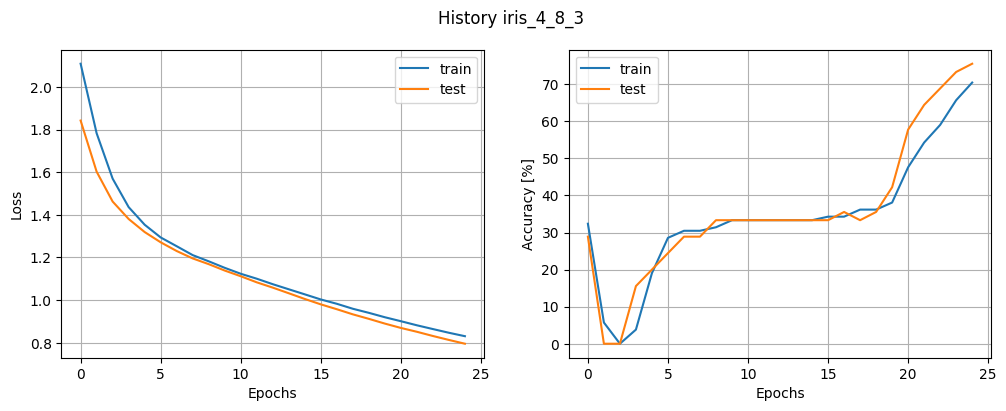

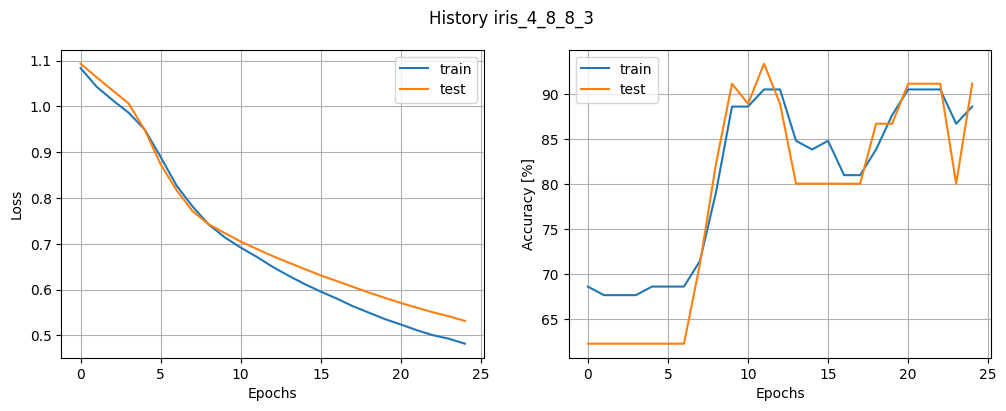

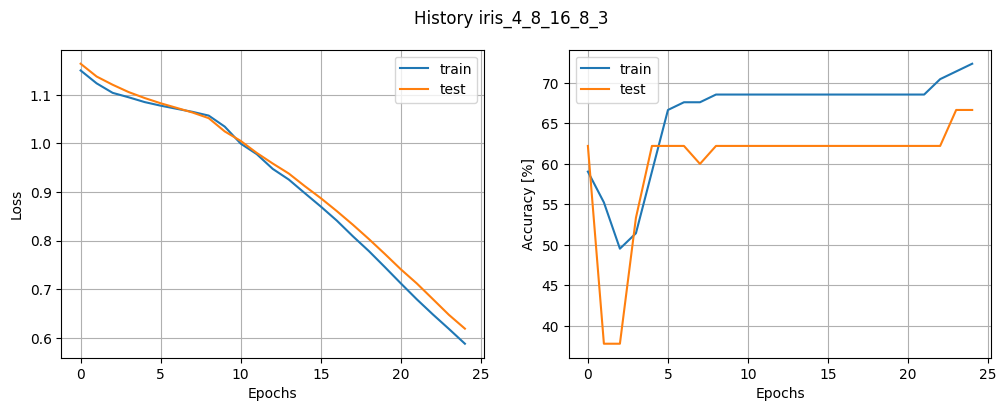

In [3]:
names = ("iris_4_8_3", "iris_4_8_8_3", "iris_4_8_16_8_3")
histories = [model_load(iris_name)[1] for iris_name in names]

_ = [plot_history(history, name) for name, history in zip(names, histories)]

In [4]:
for name, history in zip(names, histories):
    best_val_index = max(enumerate(history["val_accuracy"]), key=lambda x: x[1])[0]
    print(
        f"{name} accuracy={history['val_accuracy'][best_val_index]} "
        f"loss={history['val_loss'][best_val_index]}"
    )

iris_4_8_3 accuracy=0.7555555701255798 loss=0.7957466840744019
iris_4_8_8_3 accuracy=0.9333333373069763 loss=0.6886606812477112
iris_4_8_16_8_3 accuracy=0.6666666865348816 loss=0.6471555829048157


### Reprezentacja sieci łączonej

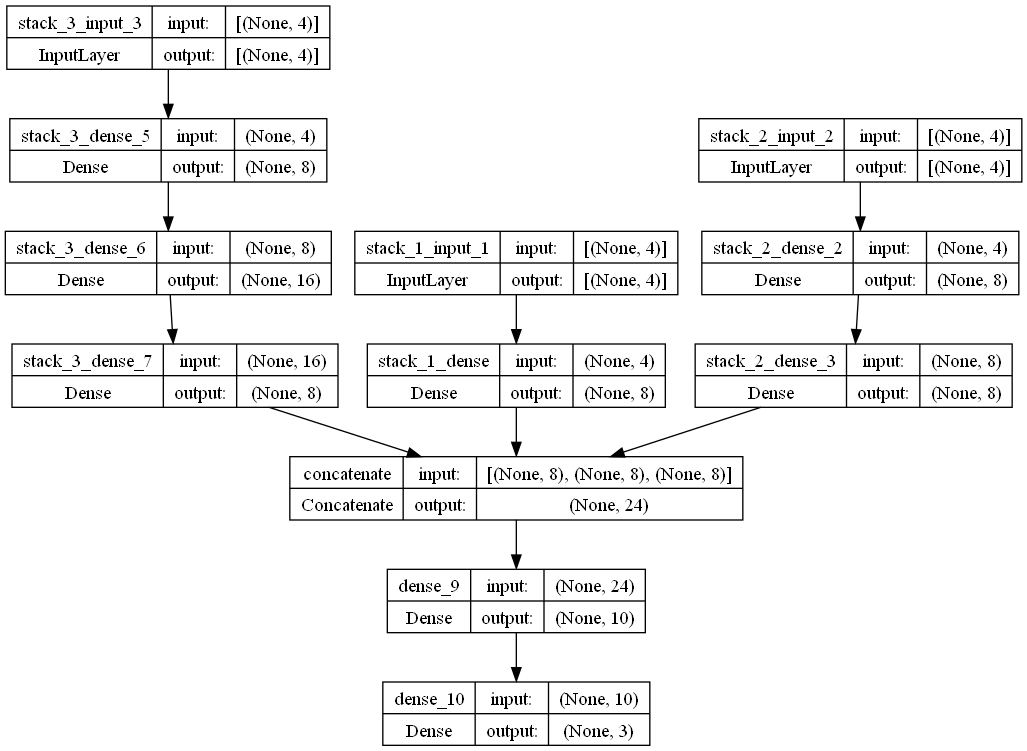

In [5]:
stacked_iris, stacked_iris_history = model_load("stacked_iris")
kutils.plot_model(stacked_iris, show_shapes=True)

### Osiągi sieci łączonej

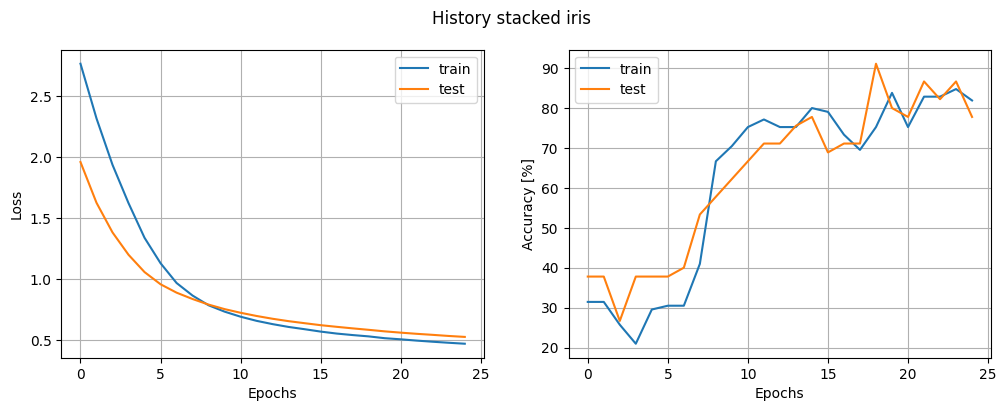

In [6]:
_ = plot_history(stacked_iris_history, 'stacked iris')

In [7]:
best_val_index = max(enumerate(stacked_iris_history["val_accuracy"]), key=lambda x: x[1])[0]
print(
    f"stacked iris accuracy={stacked_iris_history['val_accuracy'][best_val_index]} "
    f"loss={stacked_iris_history['val_loss'][best_val_index]}"
)

stacked iris accuracy=0.9111111164093018 loss=0.5821646451950073


## Mniej podstawowa sieć uczona przez łączenie

Sieć o podobnej budowie co poprzednia tym razem uczona na odrobinę trudniejszym zestawie danych [covtype](https://scikit-learn.org/stable/datasets/real_world.html#covtype-dataset). Tym razem ilość epok uczenia nie była sztucznie zmniejszana.

### Dane
|Parametr|Wartość|
|-|-|
|Liczba cech|54|
|Liczba klas|8|
|Liczność zestawu treningowego|464,809|
|Liczność zestawu testowego|116,202|

### Sieć
|Sieć|Typ|Rozmiary warstw|Liczba epok|Batch size|
|-|-|-|-|-|
|Podsieć 1|DenseFeedForward|54, 27, 8|100|256|
|Podsieć 2|DenseFeedForward|54, 108, 54, 8|100|256|
|Podsieć 3|DenseFeedForward|54, 108, 216, 54, 8|100|256|
|Nadsieć|DenseFeedForward|270, 135, 8|100|256|

### Osiągi podsieci

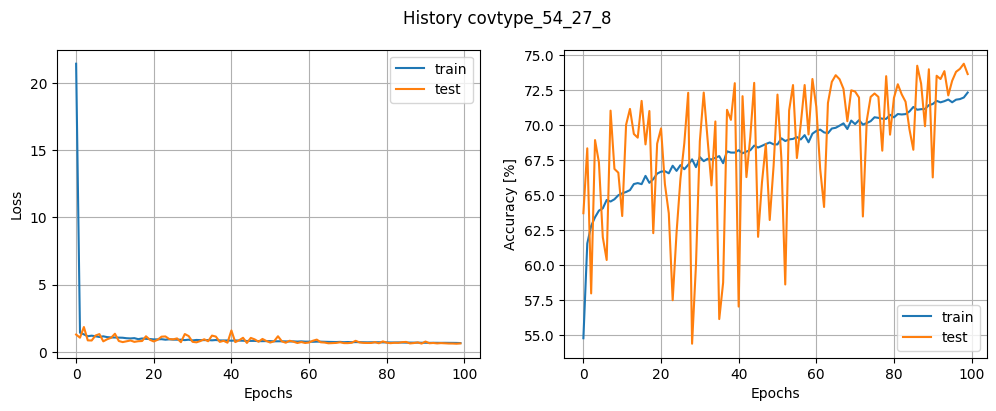

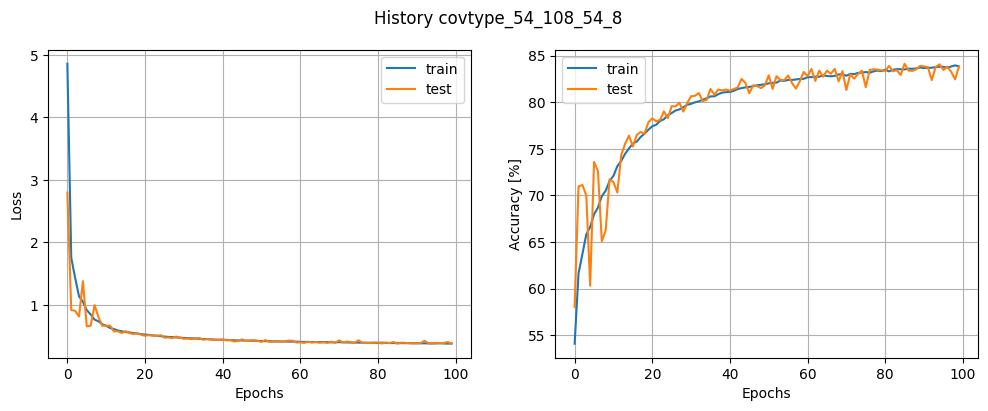

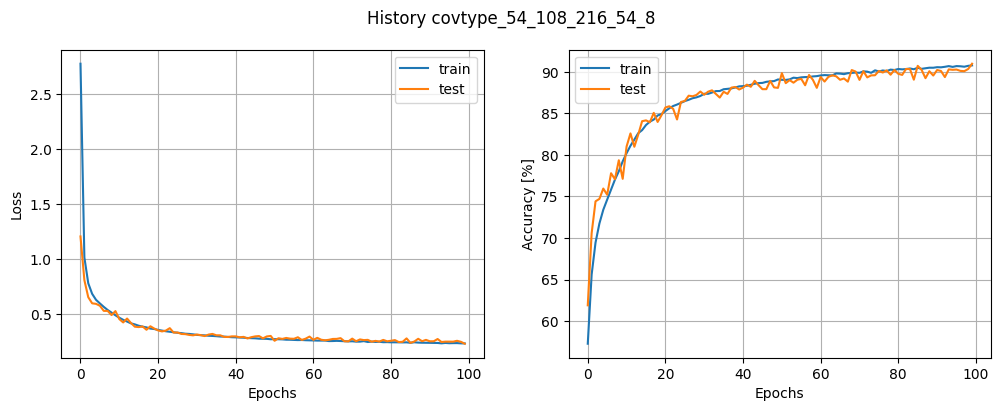

In [8]:
names = ("covtype_54_27_8", "covtype_54_108_54_8", "covtype_54_108_216_54_8")
histories = [model_load(iris_name)[1] for iris_name in names]

_ = [plot_history(history, name) for name, history in zip(names, histories)]

In [9]:
for name, history in zip(names, histories):
    best_val_index = max(enumerate(history["val_accuracy"]), key=lambda x: x[1])[0]
    print(
        f"{name} accuracy={history['val_accuracy'][best_val_index]} "
        f"loss={history['val_loss'][best_val_index]}"
    )

covtype_54_27_8 accuracy=0.7439653277397156 loss=0.5970847606658936
covtype_54_108_54_8 accuracy=0.8412089347839355 loss=0.38107621669769287
covtype_54_108_216_54_8 accuracy=0.9099678993225098 loss=0.22657863795757294


### Reprezentacja sieci łączonej

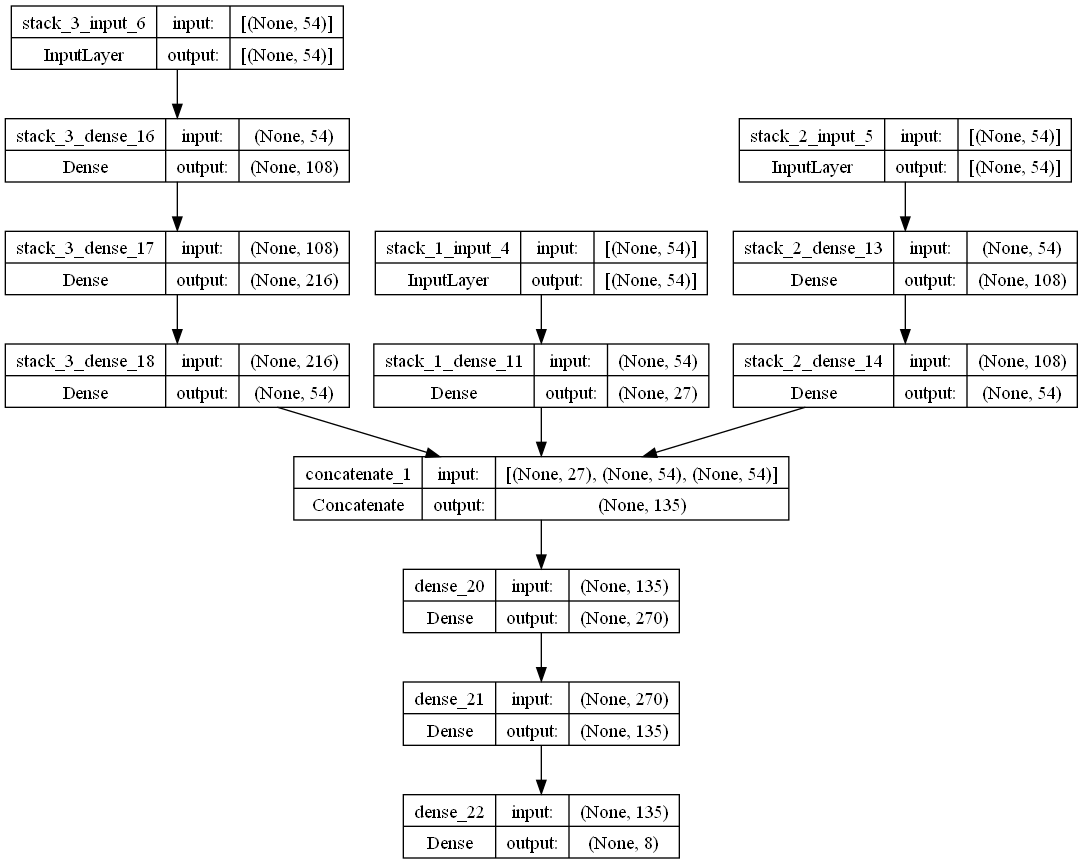

In [10]:
stacked_covtype, stacked_covtype_history = model_load("stacked_covtype")
kutils.plot_model(stacked_covtype, show_shapes=True)

### Osiągi sieci łączonej

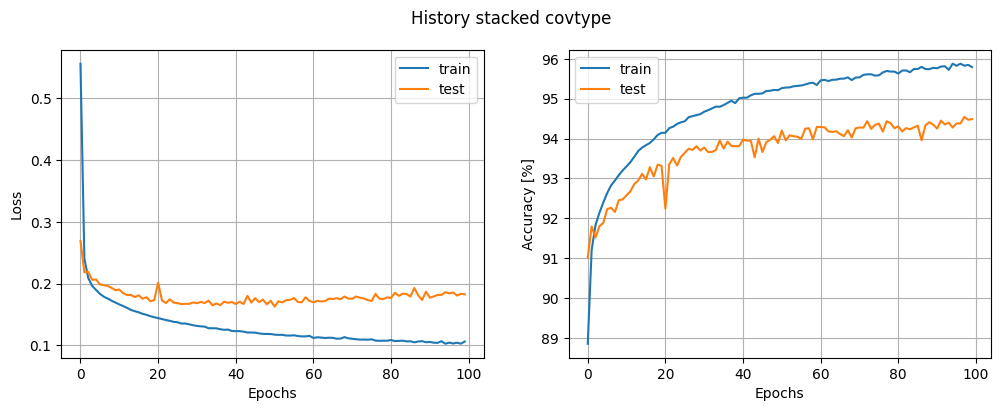

In [11]:
_ = plot_history(stacked_covtype_history, 'stacked covtype')

In [12]:
best_val_index = max(enumerate(stacked_covtype_history["val_accuracy"]), key=lambda x: x[1])[0]
print(
    f"stacked iris accuracy={stacked_covtype_history['val_accuracy'][best_val_index]} "
    f"loss={stacked_covtype_history['val_loss'][best_val_index]}"
)

stacked iris accuracy=0.9453972578048706 loss=0.1807180643081665


## Wpływ ilości identycznych podsieci na sieć łączoną

W tym teście wyuczono 10 podsieci o identycznej budowie na zestawie danych covtype.

|Sieć|Typ|Rozmiary warstw|Liczba epok|Batch size|
|-|-|-|-|-|
|Podsieć N|DenseFeedForward|54, 108, 216, 54, 8|100|256|

Następnie zbadano jakie będą wyniki dla sieci łączonych zbudowanych na od 2 do 10 podsieciach.
Rozmiary warstw nadsieci były ustalone według poniższego wzoru:
```
[54 * (ilość_podsieci + 1)], [27 * (ilość_podsieci + 1)], [8]
```

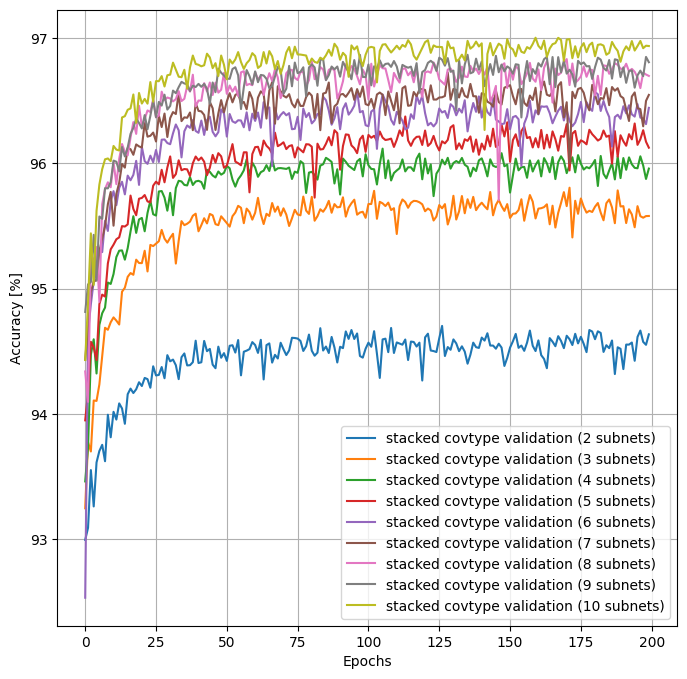

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(2,11):
    name = f"stacked covtype validation ({i} subnets)"
    model, history = model_load(f"stacked_covtype_same_n{i:02d}")
    plot_acc(history, ax, types=["test"], custom_label=name)

## SNN na pretrenowanych sieciach SOTA (podproblem)

Sięc stworzona na podstawie 3 pretrenowanych sieci: [VGG19](https://arxiv.org/abs/1409.1556), [InceptionV3](https://arxiv.org/abs/1512.00567) i [ResNet50V2](https://arxiv.org/abs/1603.05027).

Powyższe sieci były uczone na zestawie danych [imagenet](https://www.image-net.org/). Sieci te zostały połączone w sieć SNN poprzez nadsieć o parametrach:

|Sieć|Typ|Rozmiary warstw|Liczba epok|Batch size|
|-|-|-|-|-|
|Nadsieć|DenseFeedForward|1024, 512, 120|10|30|

Tak stworzone SNN zostało poddane uczeniu na zestawie danych [stanford dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/) który jest podzbiorem imagenet.

### Dane
|Parametr|Wartość|
|-|-|
|Wymiary danych|(x,y,3)|
|Liczba klas|120|
|Liczność zestawu treningowego|12,000|
|Liczność zestawu testowego|8,580|

### Osiągi podsieci

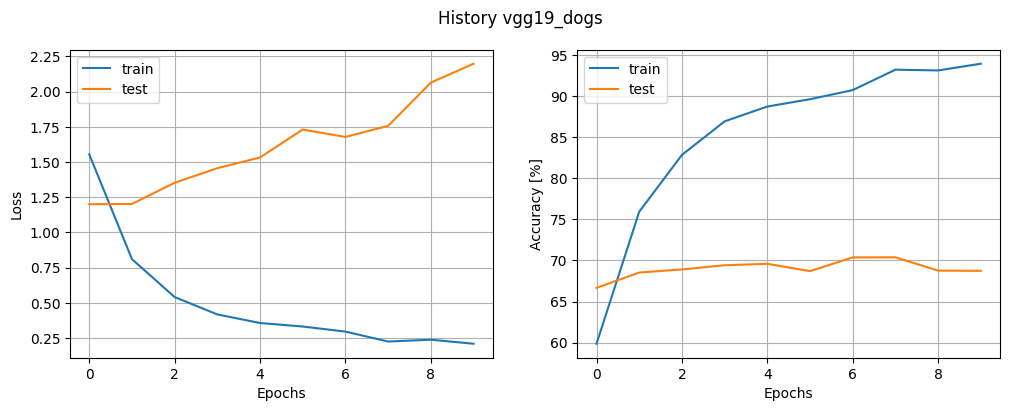

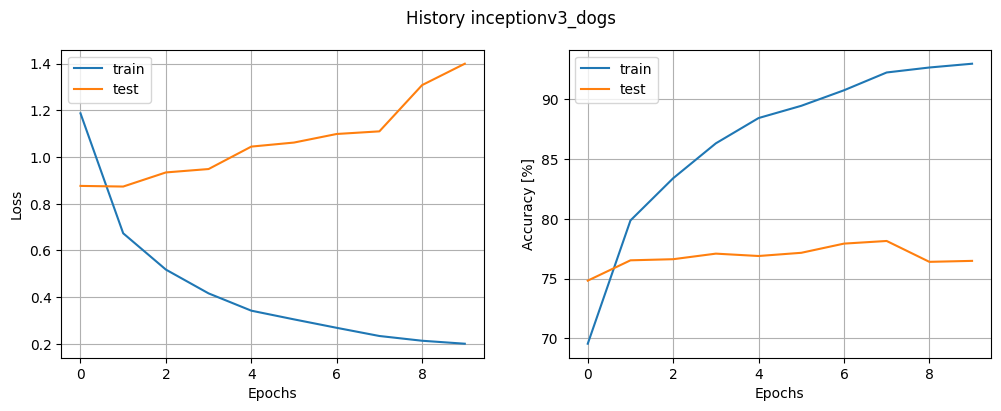

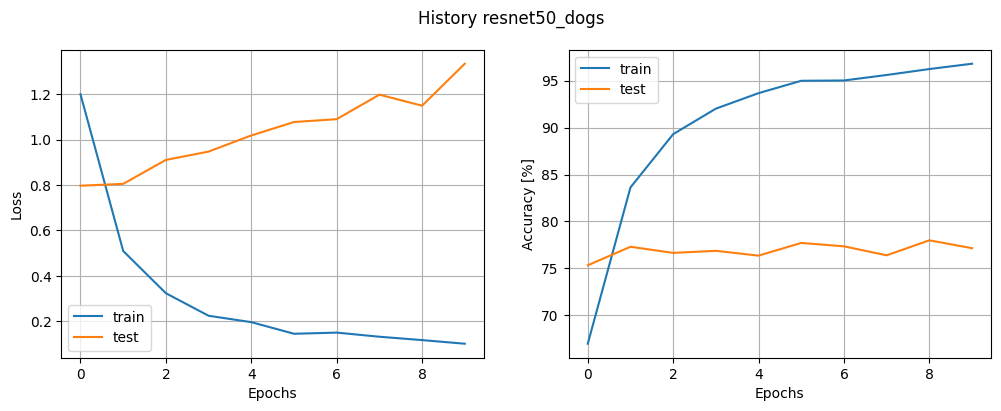

In [14]:
names = ("vgg19_dogs", "inceptionv3_dogs", "resnet50_dogs")
histories = [model_load(iris_name)[1] for iris_name in names]

_ = [plot_history(history, name) for name, history in zip(names, histories)]

In [15]:
for name, history in zip(names, histories):
    best_val_index = max(enumerate(history["val_accuracy"]), key=lambda x: x[1])[0]
    print(
        f"{name} accuracy={history['val_accuracy'][best_val_index]} "
        f"loss={history['val_loss'][best_val_index]}"
    )

vgg19_dogs accuracy=0.7038461565971375 loss=1.756470799446106
inceptionv3_dogs accuracy=0.7814685106277466 loss=1.109901785850525
resnet50_dogs accuracy=0.7799533605575562 loss=1.1494208574295044


### Reprezentacja sieci łączonej

In [16]:
stacked_covtype, stacked_covtype_history = model_load("vgg19_inceptionv3_resnet50_dogs")
kutils.plot_model(stacked_covtype, show_shapes=True)

### Osiągi sieci łączonej

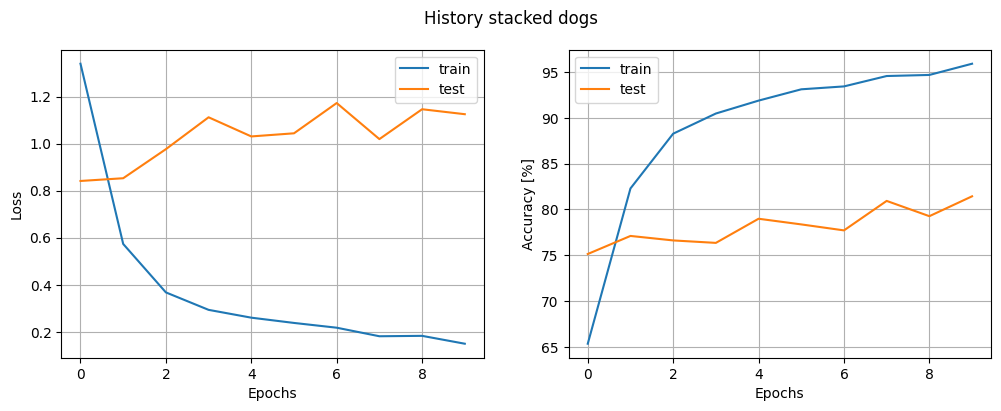

In [17]:
_ = plot_history(stacked_covtype_history, 'stacked dogs')

In [18]:
best_val_index = max(enumerate(stacked_covtype_history["val_accuracy"]), key=lambda x: x[1])[0]
print(
    f"stacked dogs accuracy={stacked_covtype_history['val_accuracy'][best_val_index]} "
    f"loss={stacked_covtype_history['val_loss'][best_val_index]}"
)

stacked dogs accuracy=0.8143356442451477 loss=1.124786615371704


## SNN na pretrenowanych sieciach SOTA (nowy problem)

Sieć została zbudowana na tych samych podsieciach co w poprzednim przykładzie. Sieci te zostały połączone w sieć SNN poprzez nadsieć o parametrach:

|Sieć|Typ|Rozmiary warstw|Liczba epok|Batch size|
|-|-|-|-|-|
|Nadsieć|DenseFeedForward|1024, 512, 200|10|30|

Tak stworzone SNN zostało poddane uczeniu na zestawie danych [caltech birds](http://www.vision.caltech.edu/datasets/cub_200_2011/). Ten zestaw już nie jest podzbiorem imagenet.

### Dane
|Parametr|Wartość|
|-|-|
|Wymiary danych|(x,y,3)|
|Liczba klas|200|
|Liczność zestawu treningowego|5,994|
|Liczność zestawu testowego|5,794|

### Osiągi podsieci

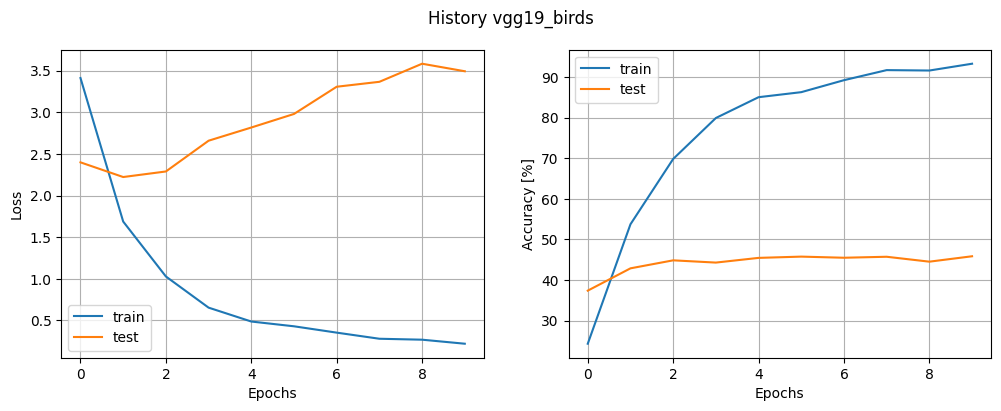

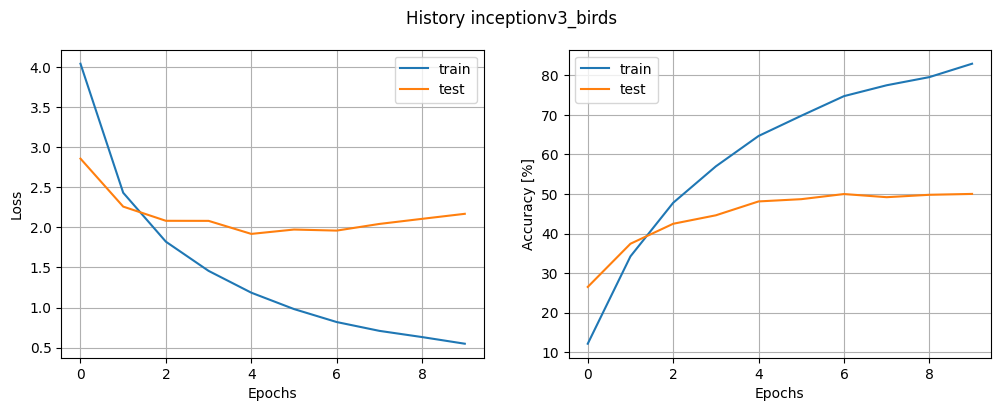

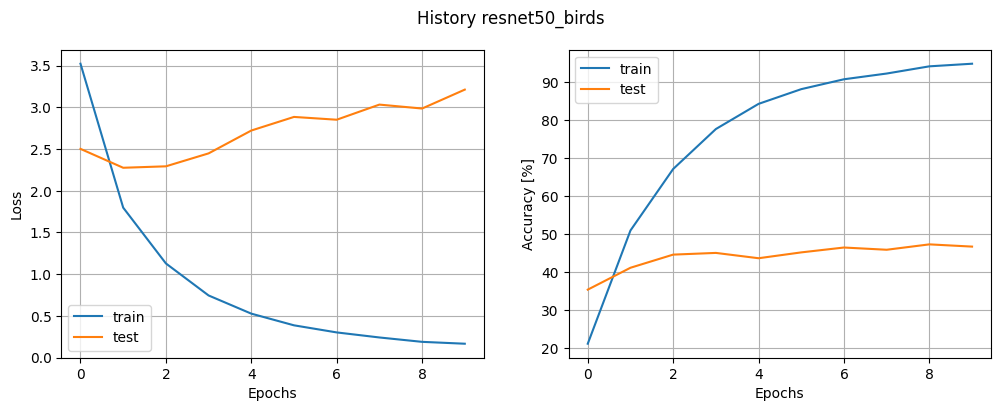

In [19]:
names = ("vgg19_birds", "inceptionv3_birds", "resnet50_birds")
histories = [model_load(iris_name)[1] for iris_name in names]

_ = [plot_history(history, name) for name, history in zip(names, histories)]

In [20]:
for name, history in zip(names, histories):
    best_val_index = max(enumerate(history["val_accuracy"]), key=lambda x: x[1])[0]
    print(
        f"{name} accuracy={history['val_accuracy'][best_val_index]} "
        f"loss={history['val_loss'][best_val_index]}"
    )

vgg19_birds accuracy=0.45854923129081726 loss=3.4912497997283936
inceptionv3_birds accuracy=0.5001727342605591 loss=2.1684987545013428
resnet50_birds accuracy=0.47305700182914734 loss=2.9851460456848145


### Reprezentacja sieci łączonej

In [21]:
stacked_covtype, stacked_covtype_history = model_load("vgg19_inceptionv3_resnet50_birds")
kutils.plot_model(stacked_covtype, show_shapes=True)

### Osiągi sieci łączonej

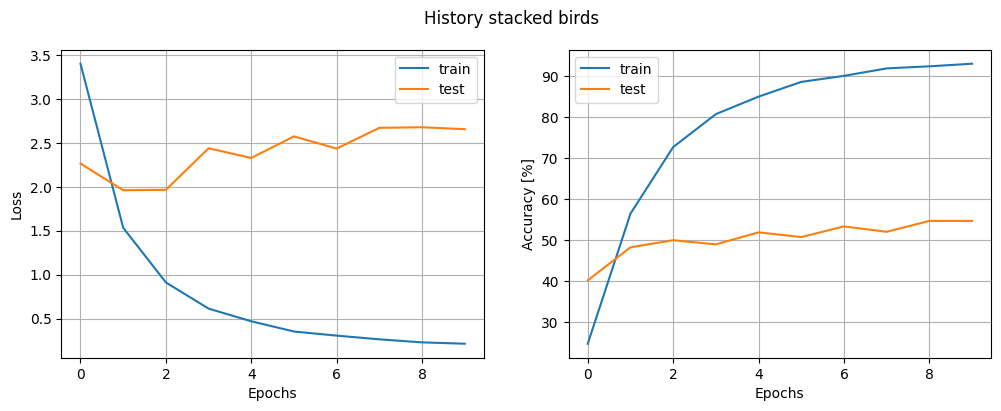

In [22]:
_ = plot_history(stacked_covtype_history, 'stacked birds')

In [23]:
best_val_index = max(enumerate(stacked_covtype_history["val_accuracy"]), key=lambda x: x[1])[0]
print(
    f"stacked birds accuracy={stacked_covtype_history['val_accuracy'][best_val_index]} "
    f"loss={stacked_covtype_history['val_loss'][best_val_index]}"
)

stacked birds accuracy=0.5471502542495728 loss=2.677504301071167
